In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

In [2]:
donkeys = pd.read_csv("donkeys.csv")
donkeys = donkeys.drop(['WeightAlt'], axis=1)
donkeys = donkeys[(donkeys['BCS'] >= 1.5) & (donkeys['BCS'] <= 4) & (donkeys['Weight'] >= 40)]


indices = np.arange(len(donkeys))
np.random.seed(42)
np.random.shuffle(indices)

n_train = int(np.round((len(donkeys)*0.8)))
n_test = len(donkeys) - n_train

train_set = donkeys.iloc[indices[ :n_train], ]
test_set = donkeys.iloc[indices[ n_train:], ]

# Modeling a Donkey's Weight

We want to build a simple model for predicting the weight of a donkey. The model should be easy for a vet to implement in the field with only a hand calculator, and it should be easy to interpret for the vet. 
We also want the model to depend on the vet's situation: whether they need to prescribe an antibiotic or an anesthetic. For brevity, we consider the case of prescribing an anesthetic; in the exercises, you have the chance to create a model for prescribing antibiotics. 

Our first step is to choose a loss function that reflects this situation. 

## A Loss Function for Prescribing Anesthetics

An over estimate of a donkey's weight when prescribing an anesthetic can have serious consequences. For this reason we don't want symmetric loss.  That is, we want a function that has a greater loss for, say, an overestimate of 10\% than an underestimate of 10\%. We have created a loss function, `an_loss`, with this feature. The plot shows the asymmetry for the relative error: $100(y - \hat{y})/\hat{y}$, where $y$ is the true value and $\hat{y}$ is the prediction. Negative values reflect an overestimate. 

In [25]:
def an_loss(x):
    w = (x >= 0) + 3 * (x < 0)
    return np.square(x) * w

Text(0, 0.5, 'Loss')

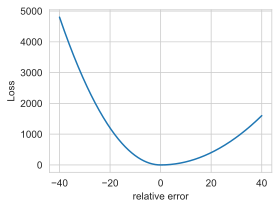

In [26]:
xs = np.linspace(-40, 40, 500)
loss = an_loss(xs)

plt.plot(xs, loss, label="Modified Quadratic Loss")
plt.xlabel(r"relative error")
plt.ylabel(r"Loss")

We will use this function when we fit models to the training data. To begin, let's fit a simple linear model.

## Fitting a Simple Linear Model

We saw that girth has the highest correlation with weight among the donkey's in our training set. So, we fit a model of the form: 

$$
f_\theta (\textbf{x}) = \theta_0 + \theta_1 Girth
$$

To find the best fitting $\theta_0$ and $\theta_1$, we create the design matrix of girth and the constant, which we call $X$, and we create the $y$ vector of weights. 

In [27]:
y = train_set['Weight']
X = train_set[['Girth']]
X_w1 = np.hstack([X.values, np.ones((len(X), 1))])

We want to minimize the loss in estimating $y$ with $\theta_0 + \theta_1 Girth$ with respect to the parameters $\theta_0$ and $\theta_1$. 
To do this we use the `minimize` method in the `scipy.optimize`. We create a wrapper function for `an_loss` that accepts our design matrix, $X$, parameter values, $\theta$s, and $y$, and constructs the relative error needed by `an_loss`. 

In [28]:
from scipy.optimize import minimize

def an_loss_rel(theta, X, y):
    yhat = X @ theta
    return np.mean(an_loss(100*(y - yhat) / yhat))

We're now ready to find the best linear model for predicting weight from girth, using our anesthetic loss function. 

In [29]:
results = minimize(lambda theta: an_loss_rel(theta, X_w1, y), np.ones(2))

We extract the minimizing parameter values and create the predictions with: 

In [30]:
theta_est = results['x']
y_pred = X_w1 @ theta_est

Let's examine the errors in our predictions as a percentage of the predicted value.

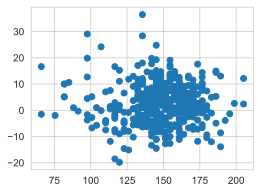

In [31]:
resids = 100 * (y - y_pred)/y_pred
plt.scatter(y_pred, resids)

With the simplest model, some of the predictions are off by 20 to 30 percent. Let's see if a slightly more complicated model improves the predictions. 

## Fitting a Multiple Linear Model 

We have three possible numeric explanatory variables, and we can fit all seven possible models formed by the various combinations of these features. We use `combinations` in the `itertools` library to construct these combinations.  

In [32]:
import itertools

models = []
response_vars = ['Girth', 'Length', 'Height']

for L in range(1, len(response_vars)+1):
  for subset in itertools.combinations(response_vars, L):
    models.append(list(subset))
    
models

[['Girth'],
 ['Length'],
 ['Height'],
 ['Girth', 'Length'],
 ['Girth', 'Height'],
 ['Length', 'Height'],
 ['Girth', 'Length', 'Height']]

Looping over each combination of features, we find the parameter estimates that minimize the average error for each model.

In [33]:
risk_mods = []

for a_mod in models:
    X = train_set[a_mod]
    X_1 = np.hstack([X.values, np.ones((len(X), 1))])
    res = minimize(lambda theta: an_loss_rel(theta, X_1, y), np.ones(len(a_mod)+1))
    theta_est = res['x']
    y_pred = X_1 @ theta_est
    risk_mods.append((np.mean(an_loss(100 * (y - y_pred)/ y_pred))))

Below, we compare the average error, or risk, for these seven fitted models. 

In [34]:
for i in range(0, 7): 
    print(models[i], risk_mods[i])

['Girth'] 94.36269797875123
['Length'] 200.54900898899834
['Height'] 268.87904718045996
['Girth', 'Length'] 65.65383972158509
['Girth', 'Height'] 86.18257949276183
['Length', 'Height'] 151.14747194389452
['Girth', 'Length', 'Height'] 63.43690848121743


As we stated earlier, the girth of the donkey is the single best predictor for weight. However, the combination of  girth and length has quite a bit smaller average loss than girth alone, and this particular two-variable model is nearly as good as the model that includes all three. Keeping in mind the desire for a simple model, we select the two-variable model over the three-variable.  But, the categorical variables may lead to an even better model. 

## Bringing Qualitative Features into the Model

In our exploratory analysis, we found that the box plots of weight for donkey's body condition and age might contain useful information in predicting weight. We can use the categorical variables to adjust the constant (or "bias") in our model for each category. To explain, recall that our current model includes girth and length: 

$$
\theta_0 + \theta_1 Girth + \theta_2 Length
$$

If the age feature consists of three age categories, "under 2", "2 to 5", and "over 5", then we create 0-1 features (that is, we use one-hot encoding), where the feature is 1 when a record belongs to a particular age category and 0 otherwise. We express this model as follows:

$$
\theta_0 + \theta_1 Girth + \theta_2 Length + \theta_3 Age\_Under\_2 + \theta_4 Age\_2\_to\_5,
$$

where `Age_Under_2` is 1 for a donkey under 2 and 0 otherwise, and, similarly, `Age_2_to_5` is 1 for a donkey between 2 and 5 years old and 0 otherwise. This model can be more clearly expressed as three linear models that are identical except for the size of the constant: 

$$
\begin{align}
(\theta_0 + \theta_3 ) + \theta_1 Girth + \theta_2 Length & ~~~~~~~~~~\textrm{for a donkey under 2.}\\
(\theta_0 + \theta_4 ) + \theta_1 Girth + \theta_2 Length & ~~~~~~~~~~\textrm{for~a~donkey~between~2~and~4.}\\
\theta_0  + \theta_1 Girth + \theta_2 Length & ~~~~~~~~~~\textrm{for~a~donkey~over~5.}
\end{align}
$$

Notice that we did not include a dummy variable for those donkeys over 5 because they are determined when the other two dummies are both 0.  

Let's examine which of the categorical variables most improves on our two-variable model. To do this, we first create dummy variables for the original body condition score, age, and sex features. 

In [35]:
train_wDummies = pd.get_dummies(train_set, columns=['BCS', 'Age', 'Sex'])
train_wDummies = train_wDummies.drop(['Height', 'Weight', 
                          'BCS_3.0', 'Age_5-10', 'Sex_female'], 
                         axis = 1)
train_wDummies.head()

,Length,Girth,BCS_1.5,BCS_2.0,...,Age_<2,Age_>20,Sex_gelding,Sex_stallion
230,101,116,0,0,...,0,0,0,1
74,92,117,0,0,...,0,0,0,1
354,103,123,0,0,...,0,1,0,0
87,91,111,0,0,...,0,0,0,0
473,98,123,0,0,...,0,0,1,0


We dropped one level for each categorical variable. Since `BCS`, `Age`, and `Sex` have six, six, and three categories, respectively, and we drop one category for each variable, we have added 12 dummy variables to the design matrix for a total of 14 columns, including `Girth` and `Length`. 

We fit the model that includes the dummies from all three categorical features, along with `Girth` and `Length`. 

In [36]:
X_1 = np.hstack([train_wDummies.values, np.ones((len(train_wDummies), 1))])
results = minimize(lambda theta: an_loss_rel(theta, X_1, y), np.ones(15))
theta_est = results['x']
y_pred = X_1 @ theta_est
(np.mean(an_loss(100 * (y - y_pred)/ y_pred)))

51.47218713446053

According to the average error, the model is better. However, we want to examine the coefficients for the dummies to see if a simpler model might be just as effective. Below is a plot of the coefficients for each of the dummy variables.

In [38]:
train_wDummies.columns.values

array(['Length', 'Girth', 'BCS_1.5', 'BCS_2.0', 'BCS_2.5', 'BCS_3.5',
       'BCS_4.0', 'Age_10-15', 'Age_15-20', 'Age_2-5', 'Age_<2',
       'Age_>20', 'Sex_gelding', 'Sex_stallion'], dtype=object)

In [39]:
dummy_ind = [2, 3, 4, 5, 6, 10, 9, 7, 8, 11, 12, 13]

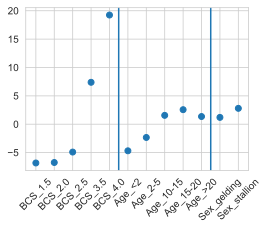

In [40]:
plt.scatter(x= range(len(dummy_ind)), y= theta_est[dummy_ind])
plt.xticks(range(len(dummy_ind)), train_wDummies.columns.values[dummy_ind],
          rotation = 45)
plt.axvline(x=4.5)
plt.axvline(x=9.5)

The coefficients confirm what we saw in the box plots. The coefficients for the sex of the donkey are close to zero, meaning that knowing the sex doesn't really change the model. We also see that combining the age categories for donkeys over 5 will simplify the model without losing much. Since there are so few donkeys with a body condition score of 1.5, we are inclined to collapse these two categories as well. 

We update the design matrix in view of these findings and refit the simpler model.

In [41]:
train_wDummies['BCS_2.0'] = train_wDummies['BCS_2.0'] + train_wDummies['BCS_1.5']
train_wDummies = train_wDummies.drop(['BCS_1.5', 
                                      'Age_10-15', 'Age_15-20', 'Age_>20',
                                      'Sex_gelding', 'Sex_stallion'], 
                         axis = 1)

In [42]:
X_1 = np.hstack([train_wDummies.values, np.ones((len(train_wDummies), 1))])
results = minimize(lambda theta: an_loss_rel(theta, X_1, y), np.ones(9))
theta_est = results['x']
y_pred = X_1 @ theta_est
np.mean(an_loss(100 * (y - y_pred)/ y_pred))

53.20369817973034

The average error is close enough to that of the more complex model for us to settle on this simpler one. Let's display the coefficients, and summarize the model. 

In [43]:
name_vars = train_wDummies.columns.values
name_vars = np.append(name_vars, "theta0")

for i in range(0, 9): 
    print(name_vars[i], theta_est[i])

Length 1.0125794089717444
Girth 1.9745313548988621
BCS_2.0 -6.326981546955034
BCS_2.5 -5.111379574152733
BCS_3.5 7.361721974135387
BCS_4.0 20.045914981980044
Age_2-5 -3.470734730105586
Age_<2 -6.487011994176165
theta0 -175.25339314397604


Our model is roughly:

$$weight \approx -175 + Length + 2\times Girth$$

After this initial approximation, we use the categorical features to make some corrections: subtract 6 kg for a donkey with a BCS of 2 or less; subtract 5 kg for a BCS of 2.5; add 7 kg for a BCS of 3.5; and add 20 kg for a BCS of 4. In addition, we also subtract 6.5 kg for a donkey under 2 years old, and subtract 3.5 kg for a donkey between 2 and 5 years old. 

This model seems quite simple to implement. Let's see how well the model does in predicting the weights of the donkeys in the test set. 

## Model Assessment

Remember that we put aside 20\% of our data before exploring and modeling with the remaining 80\%. We are now ready to apply what we have learned from the training set to the test set. That is, we will use this fitted model to predict the weights of the donkeys in the test set.
To do this, we need to prepare the test set. Our model uses the girth and length of the donkey, as well as dummy variables for the donkey's age and body condition score. 

In [44]:
y_test = test_set['Weight']

test_wDummies = pd.get_dummies(test_set, columns=['BCS', 'Age'])
test_wDummies['BCS_2.0'] = test_wDummies['BCS_2.0'] + test_wDummies['BCS_1.5']

test_wDummies = test_wDummies.drop(['Height', 'Weight', 'Sex', 
                                    'BCS_1.5', 'BCS_3.0', 
                        'Age_5-10', 'Age_10-15', 'Age_15-20', 'Age_>20'], 
                         axis = 1)

X_1_test = np.hstack([test_wDummies.values, np.ones((len(test_wDummies), 1))])

We consolidated all of our manipulations of the design matrix to create the final version that we settled on in our modeling with the training set. Now we are ready to use the $\theta$s that we fitted with the training set to make weight predictions for those donkeys in the test set. 

In [45]:
y_pred_test = X_1_test @ theta_est
error_rate_test = 100 * (y_test - y_pred_test)/y_pred_test

Text(0, 0.5, 'Relative Error (%)')

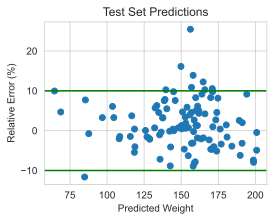

In [46]:
plt.scatter(y_pred_test, error_rate_test)
plt.axhline(y=10, color="green")
plt.axhline(y=-10, color="green")
plt.title("Test Set Predictions")
plt.xlabel("Predicted Weight")
plt.ylabel("Relative Error (%)")

All but six of the test set weights are within 10\% of the predictions, and five of those that exceed 10\% err on the side of underestimation, which makes sense given that our loss function penalized overestimation more. The scatter plot below shows the actual and predicted values.

Text(0, 0.5, 'Actual Weight')

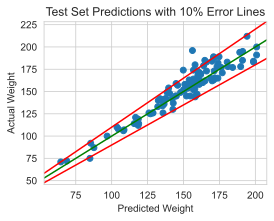

In [24]:
plt.scatter(y=y_test, x=y_pred_test)
plt.axline([60,60], [200,200], color="green")
plt.axline([60,66], [200,220], color="red")
plt.axline([60,54], [200,180], color="red")
plt.title("Test Set Predictions with 10% Error Lines")
plt.xlabel("Predicted Weight")
plt.ylabel("Actual Weight")

We take stock of the modeling exercise to conclude this chapter. 